In [16]:
!pip install numpy matplotlib



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
n = np.arange(-5,6)
x = np.array([0, 5, 6 ,7,9,0,0, -5, -9, -7, -6])
print(n)
print(x)

[-5 -4 -3 -2 -1  0  1  2  3  4  5]
[ 0  5  6  7  9  0  0 -5 -9 -7 -6]


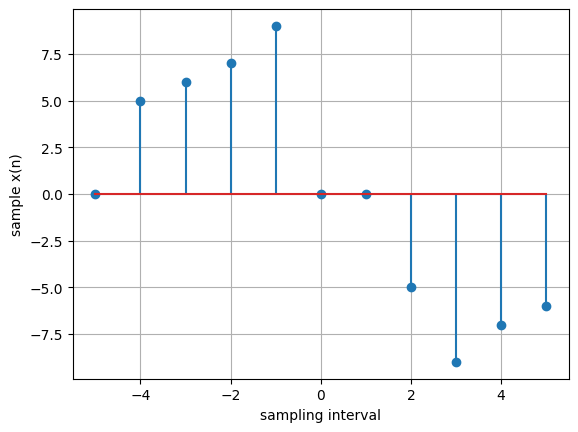

In [19]:
plt.stem(n,x)
plt.xlabel('sampling interval')
plt.ylabel('sample x(n)')
plt.grid(True)
plt.show()

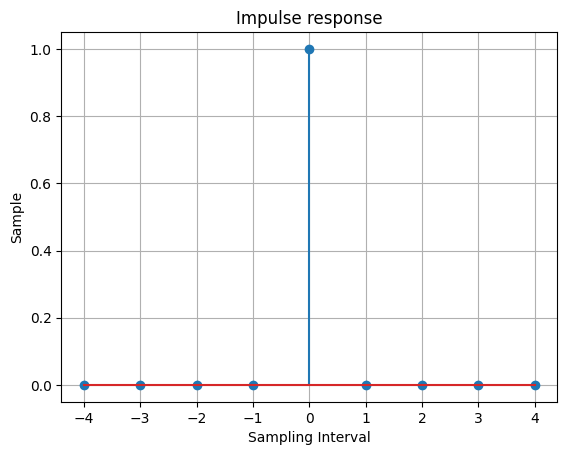

In [20]:
n = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
xn = ([ 0, 0, 0, 0, 1, 0, 0, 0, 0])
plt.stem(n,xn)
plt.title('Impulse response')
plt.xlabel('Sampling Interval')
plt.ylabel('Sample')
plt.grid(True)
plt.show()

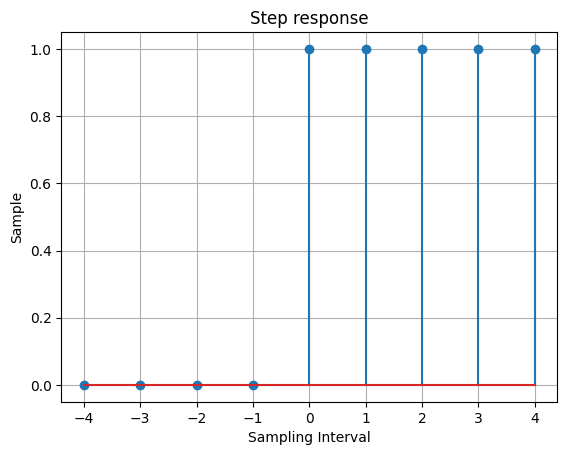

In [21]:
n = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
xn = ([ 0, 0, 0, 0, 1, 1, 1, 1, 1])
plt.stem(n,xn)
plt.title('Step response')
plt.xlabel('Sampling Interval')
plt.ylabel('Sample')
plt.grid(True)
plt.show()

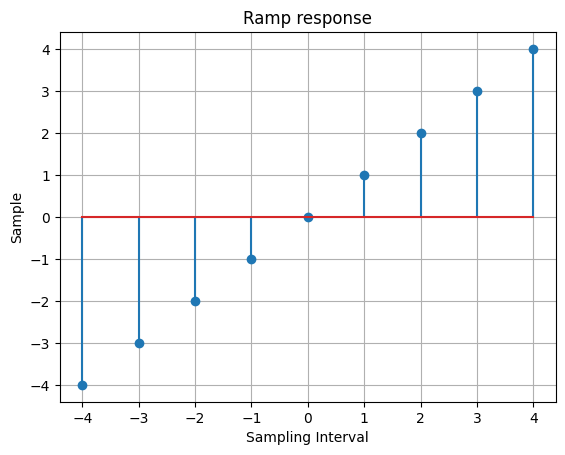

In [22]:
n = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
xn = ([-4, -3, -2, -1, 0, 1, 2, 3, 4])
plt.stem(n,xn)
plt.title('Ramp response')
plt.xlabel('Sampling Interval')
plt.ylabel('Sample')
plt.grid(True)
plt.show()

In [23]:
!pip list

Package                   Version
------------------------- -----------
altair                    5.5.0
asttokens                 3.0.0
attrs                     25.3.0
blinker                   1.9.0
cachetools                5.5.2
certifi                   2025.4.26
charset-normalizer        3.4.2
click                     8.1.8
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.2
cycler                    0.12.1
debugpy                   1.8.13
decorator                 5.2.1
dnspython                 2.7.0
executing                 2.2.0
Flask                     3.1.0
fonttools                 4.57.0
gitdb                     4.0.12
GitPython                 3.1.44
idna                      3.10
imageio                   2.37.0
ipykernel                 6.29.5
ipython                   9.0.2
ipython_pygments_lexers   1.1.1
itsdangerous              2.2.0
jedi                      0.19.2
Jinja2                    3.1.5
jsonschema          

In [24]:
!pip install opencv-python-headless


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Detected coins : 4


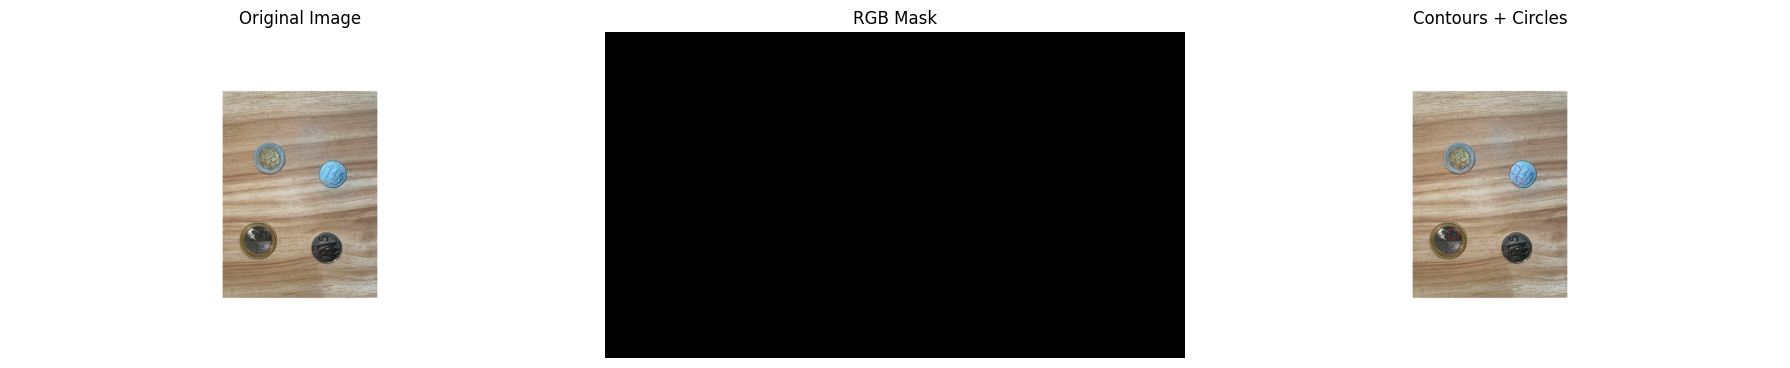

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('coin.jpg')  # Make sure the image is in your working directory
if image is None:
    print("Error: Could not load image.")
else:
    # Convert to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # ---------------------------
    # RGB Mask & Contours (kept but no print)
    # ---------------------------
    lower_rgb = np.array([150, 0, 0])
    upper_rgb = np.array([255, 80, 80])
    mask = cv2.inRange(rgb_image, lower_rgb, upper_rgb)
    
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    output_image = rgb_image.copy()
    for contour in contours:
        if cv2.contourArea(contour) > 5000:
            cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)
    
    # ---------------------------
    # Hough Circle Detection (coins)
    # ---------------------------
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=100,   # minimum distance between coin centers
        param1=80,     # Canny edge threshold
        param2=30,     # accumulator threshold for circle detection
        minRadius=40,  # adjust based on smallest coin
        maxRadius=55   # adjust based on largest coin
    )

    count_circles = 0
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for (x, y, r) in circles[0, :]:
            count_circles += 1
            cv2.circle(output_image, (x, y), r, (255, 0, 0), 2)  # circle outline in blue
            cv2.circle(output_image, (x, y), 2, (0, 0, 255), 3)  # center in red
            cv2.putText(output_image, str(count_circles), (x-10, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

    print(f"Detected coins : {count_circles}")

    # ---------------------------
    # Plot Results
    # ---------------------------
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(rgb_image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(mask_cleaned, cmap='gray')
    axs[1].set_title("RGB Mask")
    axs[1].axis('off')

    axs[2].imshow(output_image)
    axs[2].set_title("Contours + Circles")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


In [2]:
import copy

original = [[1, 2], [3, 4]]
shallow = copy.copy(original)

shallow[0][0] = 99
print(original)  # [[99, 2], [3, 4]]

[[99, 2], [3, 4]]


In [3]:
original = [[1, 2], [3, 4]]
deep = copy.deepcopy(original)

In [4]:
deep[0][0] = 99
print(original)
print(deep)

[[1, 2], [3, 4]]
[[99, 2], [3, 4]]


Detected objects: 0


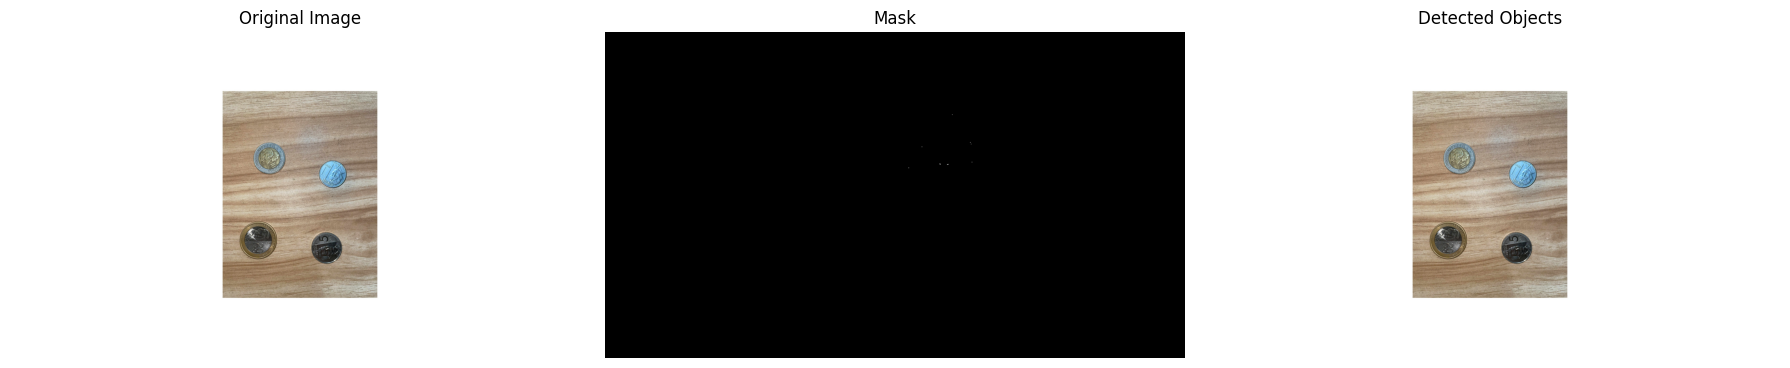

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('coin.jpg')
if image is None:
    print("Error: Could not load image.")
else:
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Red coins (HSV)
    lower1 = np.array([0, 50, 50])
    upper1 = np.array([10, 255, 255])
    lower2 = np.array([170, 50, 50])
    upper2 = np.array([180, 255, 255])

    mask = cv2.inRange(hsv, lower1, upper1)
    mask += cv2.inRange(hsv, lower2, upper2)

    # Clean mask
    kernel = np.ones((5,5), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    output_image = rgb_image.copy()
    count = 0
    for contour in contours:
        if cv2.contourArea(contour) > 5000:
            count += 1
            cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)

    print(f"Detected objects: {count}")

    # Plot images
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(rgb_image); axs[0].set_title("Original Image"); axs[0].axis('off')
    axs[1].imshow(mask_cleaned, cmap='gray'); axs[1].set_title("Mask"); axs[1].axis('off')
    axs[2].imshow(output_image); axs[2].set_title("Detected Objects"); axs[2].axis('off')
    plt.tight_layout()
    plt.show()


In [30]:
!pip install scikit-image 


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


113882.0
119247.0
101997.0
210613.0
102182.0
4008.0
5520.0
905364.0
9909.0
11854.0


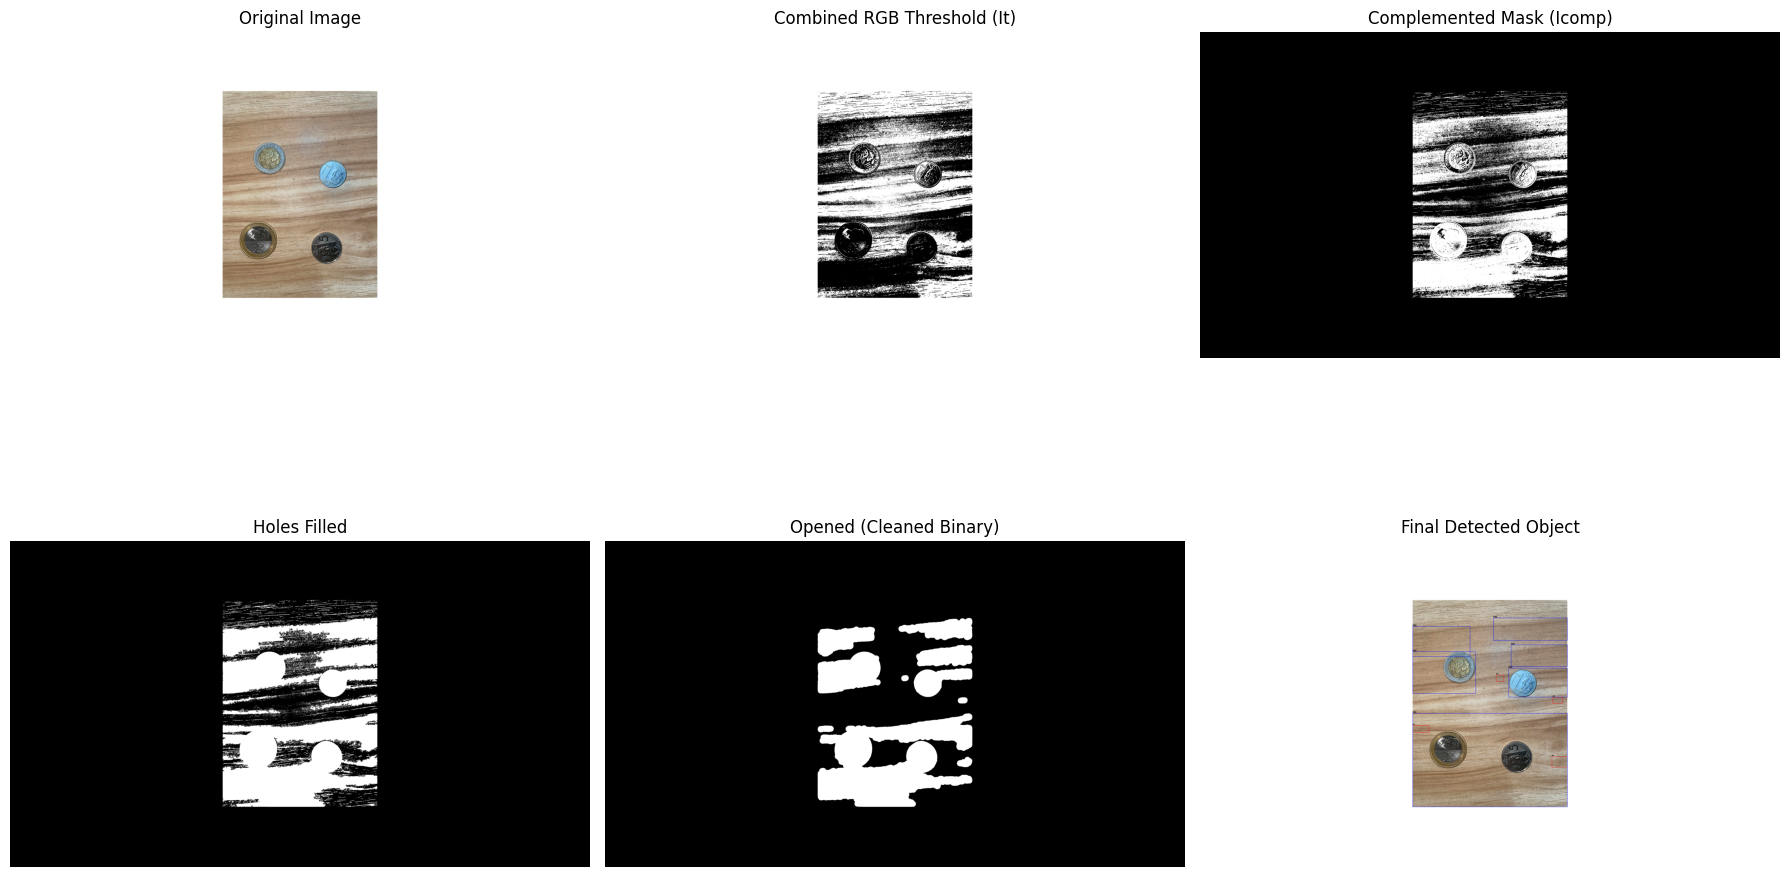

small: 4
medium: 0
large: 6
count: 10


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import disk, opening
from skimage.util import invert

# Load image
image = cv2.imread('coin.jpg')
if image is None:
    raise FileNotFoundError("Image not found.")

# Convert to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract channels
rmat = image_rgb[:, :, 0]
gmat = image_rgb[:, :, 1]
bmat = image_rgb[:, :, 2]

# Threshold levels
levelr = 0.5 * 255
levelg = 0.45 * 255
levelb = 0.5 * 255

# Threshold RGB channels
Ired = (rmat > levelr).astype(np.uint8)
Igreen = (gmat > levelg).astype(np.uint8)
Iblue = (bmat > levelb).astype(np.uint8)

# Combine channels
It = cv2.bitwise_and(cv2.bitwise_and(Ired, Igreen), Iblue)

# Invert mask
Icomp = cv2.bitwise_not(It * 255)

# Fill holes
flood_fill = Icomp.copy()
h, w = flood_fill.shape
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(flood_fill, mask, (0, 0), 255)
filled = cv2.bitwise_or(Icomp, cv2.bitwise_not(flood_fill))

# Morphological open
opened = opening(filled, disk(30)).astype(np.uint8)

# Label connected components
label_image = label(opened)
regions = regionprops(label_image) 

###
for region in regions:
        area = region.area
        centroid = region.centroid
        print(area)

# Classify objects
small, medium, large = [], [], []
for region in regions:
    area = region.area
    if area < 20000:
        small.append(region)
    elif area < 100000:
        medium.append(region)
    else:
        large.append(region)

# Draw boxes on copy of image
output_img = image_rgb.copy()
for region in small:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (255, 0, 0), 2)
    cv2.putText(output_img, 'P1', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

for region in medium:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
    cv2.putText(output_img, 'P5', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

for region in large:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 0, 255), 2)
    cv2.putText(output_img, 'P20', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

# Display results side-by-side
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

axs[0, 0].imshow(image_rgb)
axs[0, 0].set_title("Original Image")
axs[0, 0].axis("off")

axs[0, 1].imshow(It, cmap='gray')
axs[0, 1].set_title("Combined RGB Threshold (It)")
axs[0, 1].axis("off")

axs[0, 2].imshow(Icomp, cmap='gray')
axs[0, 2].set_title("Complemented Mask (Icomp)")
axs[0, 2].axis("off")

axs[1, 0].imshow(filled, cmap='gray')
axs[1, 0].set_title("Holes Filled")
axs[1, 0].axis("off")

axs[1, 1].imshow(opened, cmap='gray')
axs[1, 1].set_title("Opened (Cleaned Binary)")
axs[1, 1].axis("off")

axs[1, 2].imshow(output_img)
axs[1, 2].set_title("Final Detected Object")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

# Display total value
total_value = len(small)  + len(medium)  + len(large) 
print(f"small: {len(small)}")
print(f"medium: {len(medium)}")
print(f"large: {len(large)}")
print(f"count: {total_value}")


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import disk, opening
from skimage.util import invert

# Load image
image = cv2.imread('coin.jpg')
if image is None:
    raise FileNotFoundError("Image not found.")

# Convert to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

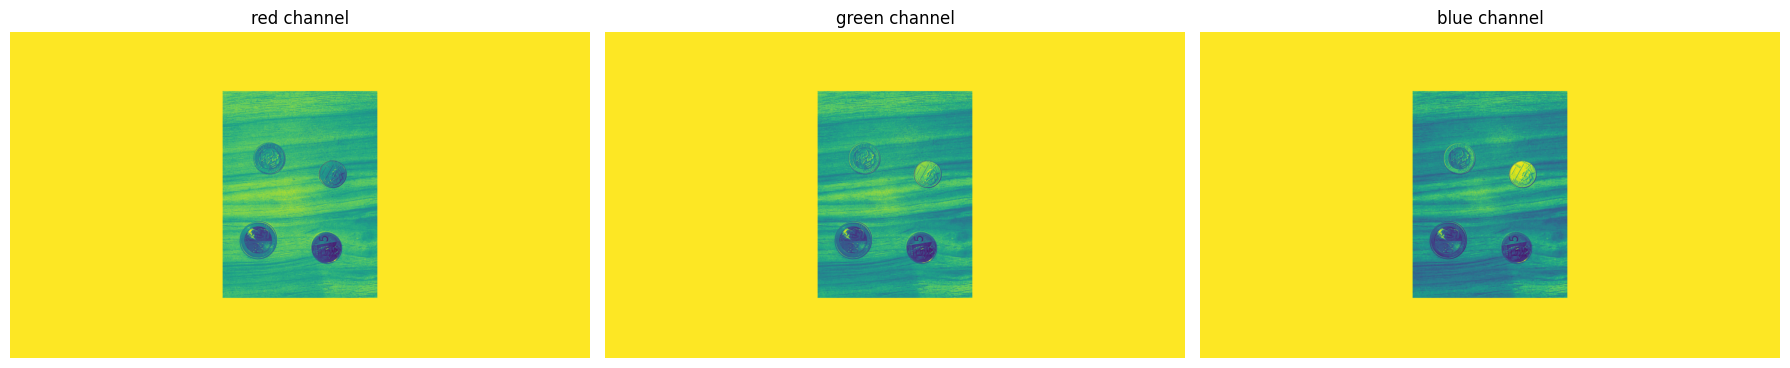

In [9]:
# Extract channels
rmat = image_rgb[:, :, 0]
gmat = image_rgb[:, :, 1]
bmat = image_rgb[:, :, 2]
#show image for each channel
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
axs[0].imshow(rmat)
axs[0].set_title("red channel")
axs[0].axis("off")

axs[1].imshow(gmat)
axs[1].set_title("green channel")
axs[1].axis("off")

axs[2].imshow(bmat)
axs[2].set_title("blue channel")
axs[2].axis("off")

plt.tight_layout()
plt.show()

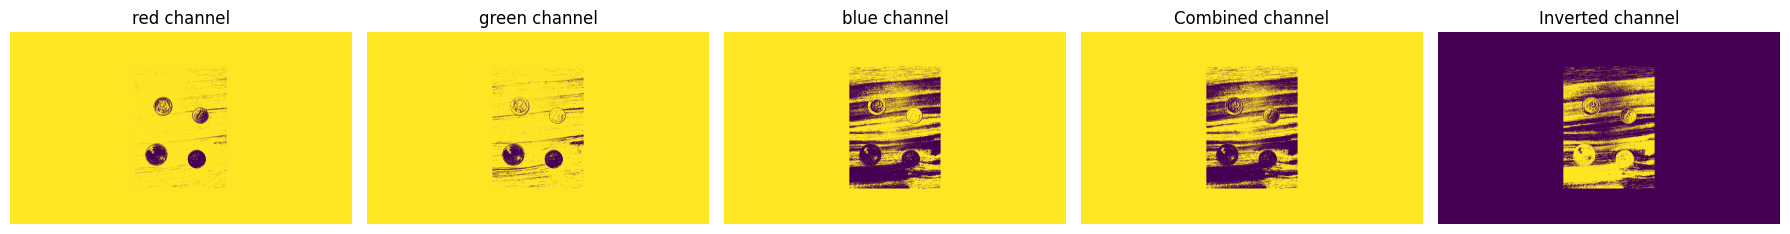

In [10]:
# Threshold levels
levelr = 0.5 * 255
levelg = 0.45 * 255
levelb = 0.5 * 255

# Threshold RGB channels
Ired = (rmat > levelr).astype(np.uint8)
Igreen = (gmat > levelg).astype(np.uint8)
Iblue = (bmat > levelb).astype(np.uint8)

# Combine channels
It = cv2.bitwise_and(cv2.bitwise_and(Ired, Igreen), Iblue)

# Invert mask
Icomp = cv2.bitwise_not(It * 255)

#show image for each channel
fig, axs = plt.subplots(1, 5, figsize=(18, 12))
axs[0].imshow(Ired)
axs[0].set_title("red channel")
axs[0].axis("off")

axs[1].imshow(Igreen)
axs[1].set_title("green channel")
axs[1].axis("off")

axs[2].imshow(Iblue)
axs[2].set_title("blue channel")
axs[2].axis("off")

axs[3].imshow(It)
axs[3].set_title("Combined channel")
axs[3].axis("off")

axs[4].imshow(Icomp)
axs[4].set_title("Inverted channel")
axs[4].axis("off")

plt.tight_layout()
plt.show()

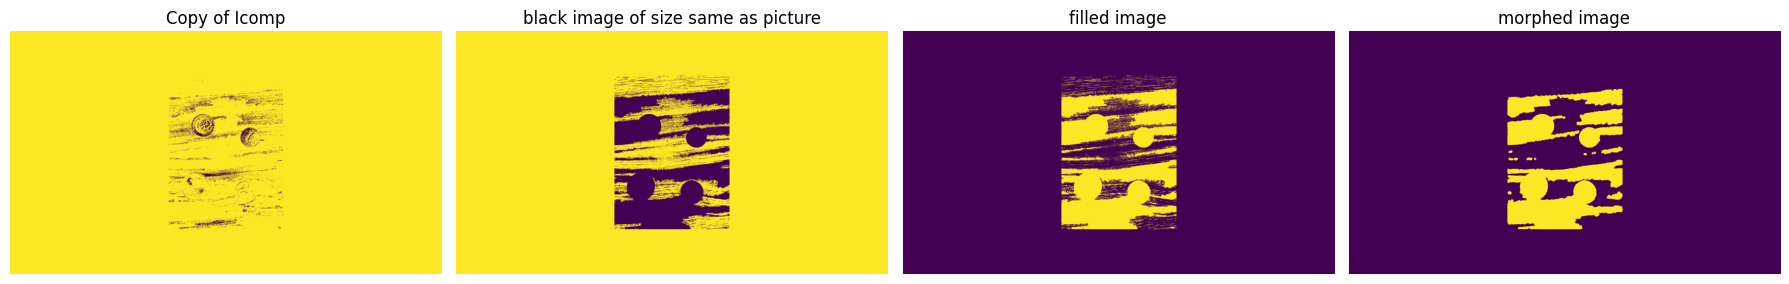

123799.0
127305.0
108090.0
236016.0
103233.0
16387.0
1555.0
1545.0
1331.0
2120.0
2603.0
1849.0
780.0
943730.0
2101.0
15415.0


In [11]:
# Fill holes
flood_fill = Icomp.copy()
h, w = flood_fill.shape
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(flood_fill, mask, (0, 0), 255)
filled = cv2.bitwise_or(Icomp, cv2.bitwise_not(flood_fill))

# Morphological open
opened = opening(filled // 255, disk(15)).astype(np.uint8)

# Label connected components
label_image = label(opened)
regions = regionprops(label_image)

#show image for each channel
fig, axs = plt.subplots(1, 4, figsize=(18, 12))
axs[0].imshow(flood_fill)
axs[0].set_title("Copy of Icomp")
axs[0].axis("off")

axs[1].imshow(mask)
axs[1].set_title("black image of size same as picture")
axs[1].axis("off")

axs[2].imshow(filled)
axs[2].set_title("filled image")
axs[2].axis("off")

axs[3].imshow(opened)
axs[3].set_title("morphed image")
axs[3].axis("off")


plt.tight_layout()
plt.show()
###
for region in regions:
        area = region.area
        print(area)

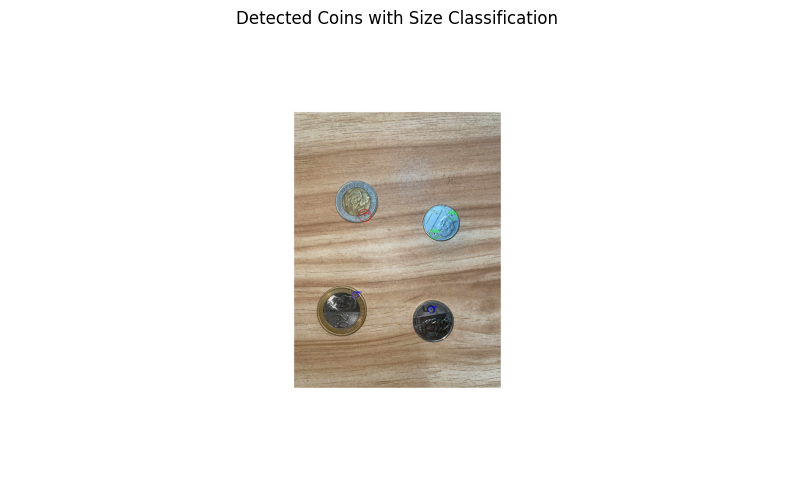

Small coins (1/5₱): 2
Medium coins (10₱): 2
Large coins (20₱): 1
Total coins detected: 5


In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('coin.jpg')  # Replace with your coin image path
if image is None:
    print("Error: Could not load image.")
    exit()

# Convert to grayscale and blur
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# Detect circles (coins)
circles = cv2.HoughCircles(
    blurred,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=60,
    param1=90,
    param2=38,
    minRadius=22,
    maxRadius=48
)

# Classify coins based on radius
small, medium, large = [], [], []

output_img = image.copy()

if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x, y, r) in circles[0, :]:
        if r < 30:
            small.append((x, y, r))
            label = '1/5₱'  # small coin
            color = (255, 0, 0)  # blue
        elif r < 45:
            medium.append((x, y, r))
            label = '10₱'
            color = (0, 255, 0)  # green
        else:
            large.append((x, y, r))
            label = '20₱'
            color = (0, 0, 255)  # red

        # Draw circle and label
        cv2.circle(output_img, (x, y), r, color, 2)
        cv2.circle(output_img, (x, y), 2, (0, 0, 0), 3)
        cv2.putText(output_img, label, (x - 20, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Display results
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Coins with Size Classification")
plt.axis("off")
plt.show()

# Print counts
total_value = len(small) + len(medium) + len(large)
print(f"Small coins (1/5₱): {len(small)}")
print(f"Medium coins (10₱): {len(medium)}")
print(f"Large coins (20₱): {len(large)}")
print(f"Total coins detected: {total_value}")


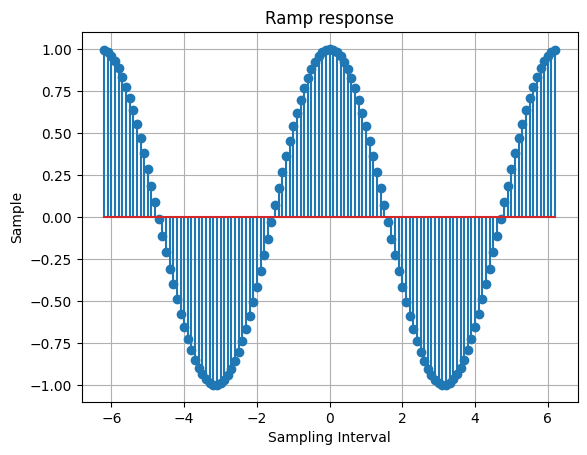

In [50]:
import numpy as np
import matplotlib.pyplot as plt

n = np.arange(-6.2,6.3,0.1) #1 and #2. n = np.arange(-3.1,3.2,0.1), #3 and #4 n = np.arange(-6.2,6.3,0.1)
xn = np.cos(n) #1 np.sin(n) #2 np.cos(n) #3 np.sin(n) #4 np.cos(n) 
plt.stem(n,xn)
plt.title('Ramp response') #Sin wave/ Cosine wave
plt.xlabel('Sampling Interval')
plt.ylabel('Sample')
plt.grid(True)
plt.show()

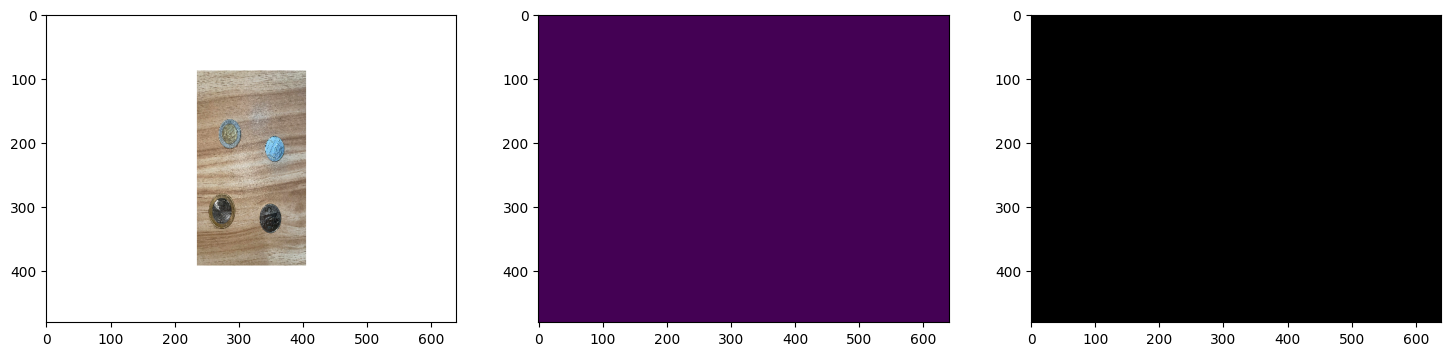

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
image = cv2.imread('coin.png')
image = cv2.resize(image, (640, 480))  # Resize if needed

# Convert to HSV
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the red color range in HSV
# Red can span across the 0 and 180 boundaries, so we need two ranges
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])

lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])

# Create masks
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

# Combine both masks
red_mask = cv2.bitwise_or(mask1, mask2)

# Apply the mask to the original image
red_result = cv2.bitwise_and(image, image, mask=red_mask)

fig, axs = plt.subplots(1, 3, figsize=(18, 12))
# Display the results
axs[0].imshow(image_rgb)
axs[1].imshow(red_mask)
axs[2].imshow(red_result)


In [6]:
import cv2
import numpy as np
import tkinter as tk
from PIL import Image, ImageTk

# Coin detection parameters
MIN_RADIUS = 20   # smallest coin radius
MAX_RADIUS = 60   # largest coin radius
MIN_DIST = 50     # minimum distance between coin centers

# Map coin radius to values (in ₱)
COIN_RANGES = {
    1: (20, 27),
    5: (28, 36),
    10: (37, 45),
    20: (46, 60)
}

def get_coin_value(radius):
    for value, (r_min, r_max) in COIN_RANGES.items():
        if r_min <= radius <= r_max:
            return value
    return 0

def detect_coins(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=MIN_DIST,
        param1=100,
        param2=30,
        minRadius=MIN_RADIUS,
        maxRadius=MAX_RADIUS
    )

    output_frame = frame.copy()
    coin_counts = {1:0, 5:0, 10:0, 20:0}
    total_value = 0

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for idx, (x, y, r) in enumerate(circles[0, :], start=1):
            value = get_coin_value(r)
            if value > 0:
                coin_counts[value] += 1
                total_value += value

                # Draw circle, center, and value
                cv2.circle(output_frame, (x, y), r, (0, 255, 0), 2)
                cv2.circle(output_frame, (x, y), 2, (0, 0, 255), 3)
                cv2.putText(output_frame, f"{value}₱", (x-20, y-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return output_frame, coin_counts, total_value

def update_frame():
    ret, frame = cap.read()
    if ret:
        frame, counts, total = detect_coins(frame)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame_rgb)
        imgtk = ImageTk.PhotoImage(image=img)
        lbl.imgtk = imgtk
        lbl.configure(image=imgtk)

        breakdown = " | ".join([f"{k}₱:{v}" for k,v in counts.items()])
        lbl_counts.config(text=f"{breakdown} | Total: {total}₱")

    root.after(10, update_frame)

# -------------------------------
# Tkinter GUI setupimport cv2
import numpy as np
import tkinter as tk
from PIL import Image, ImageTk

# Coin detection parameters
MIN_RADIUS = 20   # smallest coin radius
MAX_RADIUS = 60   # largest coin radius
MIN_DIST = 50     # minimum distance between coin centers

# Map coin radius to values (in ₱)
COIN_RANGES = {
    1: (20, 27),
    5: (28, 36),
    10: (37, 45),
    20: (46, 60)
}

def get_coin_value(radius):
    for value, (r_min, r_max) in COIN_RANGES.items():
        if r_min <= radius <= r_max:
            return value
    return 0

def detect_coins(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=MIN_DIST,
        param1=100,
        param2=30,
        minRadius=MIN_RADIUS,
        maxRadius=MAX_RADIUS
    )

    output_frame = frame.copy()
    coin_counts = {1:0, 5:0, 10:0, 20:0}
    total_value = 0

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for idx, (x, y, r) in enumerate(circles[0, :], start=1):
            value = get_coin_value(r)
            if value > 0:
                coin_counts[value] += 1
                total_value += value

                # Draw circle, center, and value
                cv2.circle(output_frame, (x, y), r, (0, 255, 0), 2)
                cv2.circle(output_frame, (x, y), 2, (0, 0, 255), 3)
                cv2.putText(output_frame, f"{value}₱", (x-20, y-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return output_frame, coin_counts, total_value

def update_frame():
    ret, frame = cap.read()
    if ret:
        frame, counts, total = detect_coins(frame)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame_rgb)
        imgtk = ImageTk.PhotoImage(image=img)
        lbl.imgtk = imgtk
        lbl.configure(image=imgtk)

        breakdown = " | ".join([f"{k}₱:{v}" for k,v in counts.items()])
        lbl_counts.config(text=f"{breakdown} | Total: {total}₱")

    root.after(10, update_frame)

# -------------------------------
# Tkinter GUI setup
# -------------------------------
root = tk.Tk()
root.title("Philippine Coin Detection")

lbl = tk.Label(root)
lbl.pack()

lbl_counts = tk.Label(root, text="", font=("Arial", 14))
lbl_counts.pack()

cap = cv2.VideoCapture(0)
update_frame()
root.mainloop() 
# -------------------------------
root = tk.Tk()
root.title("Philippine Coin Detection")

lbl = tk.Label(root)
lbl.pack()

lbl_counts = tk.Label(root, text="", font=("Arial", 14))
lbl_counts.pack()

cap = cv2.VideoCapture(0)
update_frame()
root.mainloop() 